### Library Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from data_cleaner import DataCleaner

In [ ]:
# Load training dataset
#To run the csv data, Replace 'dataset_csv_path' with the actual file path to your CSV dataset on your computer
dataset_csv_path = "..."
filePath = dataset_csv_path+ 'W-T2_A24census-4.csv'


### Data Cleaning and Visualization Functions

In [3]:
def plot_distribution(df, column, title=None, xlabel=None):
        series = df[column]
        plt.figure(figsize=(8, 4))
        sns.histplot(series.dropna(), kde=True, bins=20)
        plt.title(title or f'{column} Distribution')
        plt.xlabel(xlabel or column)
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def plot_categorical_distribution(before_df, after_df, column):
        fig, axs = plt.subplots(1, 2 if after_df is not None else 1, figsize=(16, 6))

        if after_df is not None:
            if not isinstance(axs, (list, np.ndarray)):
                axs = [axs]

            # Before Cleaning Plot
            before_df[column].value_counts(normalize=True).plot(kind='bar', ax=axs[0], color='skyblue')
            axs[0].set_title(f'Before Cleaning - {column}')
            axs[0].set_ylabel("Proportion")
            axs[0].set_xlabel("Categories")

            # After Cleaning Plot
            after_df[column].value_counts(normalize=True).plot(kind='bar', ax=axs[1], color='lightgreen')
            axs[1].set_title(f'After Cleaning - {column}')
            axs[1].set_ylabel("Proportion")
            axs[1].set_xlabel("Categories")

            for ax in axs:
                ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        else:
            # Only Before Cleaning Plot
            before_df[column].value_counts(normalize=True).plot(kind='bar', color='skyblue')
            plt.title(f'{column} Distribution (Before Cleaning)')
            plt.ylabel("Proportion")
            plt.xlabel("Categories")
            plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

def compare_old_and_cleaned_data(before, cleaned_df, columns_to_compare=None):

        after = cleaned_df.copy()

        if columns_to_compare is None:
            columns_to_compare = list(set(before.columns).intersection(after.columns))

        if 'Age' in columns_to_compare:
            plot_distribution(before, before['Age'], title='Age Distribution (Before Cleaning)', xlabel='Age')
            temp_profiler = DataProfiler(after)
            temp_profiler.plot_distribution(before, 'Age', title='Age Distribution (After Cleaning)', xlabel='Age')

        for col in columns_to_compare:
            if col != 'Age' and before[col].dtype == 'object':
                plot_categorical_distribution(before, after, col)

###  Assessing the quality of the data before cleaning

In [ ]:
original_df = pd.read_csv(filePath)
print('Data info')
print(original_df.info())

class DataProfiler:
    def __init__(self, df):
        self.df = df.copy()


    def missing_data_analysis(self):
        print("=== Missing Values Summary (NaN + Empty Strings) ===\n")
        
        report_rows = []

        for col in self.df.columns:
            # Count NaN
            num_nan = self.df[col].isna().sum()
            
            # Count Empty Strings (only for object columns)
            num_empty = 0
            if self.df[col].dtype == 'object':
                num_empty = (self.df[col].str.strip() == '').sum()

            total_missing = num_nan + num_empty
            percent_missing = (total_missing / len(self.df)) * 100

            mode_value = self.df[col].mode()
            mode_display = mode_value.iloc[0] if not mode_value.empty else 'N/A'

            # Save row for report
            report_rows.append({
                'Column': col,
                'Missing %': round(percent_missing, 2),
                'Most Frequent': mode_display
            })

        # Create a summary DataFrame
        missing_report = pd.DataFrame(report_rows)
        missing_report = missing_report.sort_values(by='Missing %', ascending=False)

        print(missing_report.to_string(index=False))

        print("\n=== Unique Values (<50) in Categorical Columns ===\n")
        for col in self.df.select_dtypes(include='object').columns:
            if self.df[col].nunique() <= 50:
                print(f"{col} (Unique: {self.df[col].nunique()})")
                print((self.df[col].value_counts(normalize=True) * 100).round(2))
                print()

        return missing_report


    def logical_consistency_checks(self):
        df = self.df
        print("\n=== Logical Consistency Checks ===")

        # 1. Existing check: 'Head of House' under 18
        if {'Age', 'Relationship to Head of House'}.issubset(df.columns):
            logic_issue = df[(df['Age'] < 18) & (df['Relationship to Head of House'] == 'Head')]
            if not logic_issue.empty:
                print(f" Number of 'Head of House' under 18 years: {len(logic_issue)}")
            else:
                print(" No 'Head of House' under 18 detected.")

        # 2. New check: Marital status + Age consistency
        if {'Age', 'Marital Status'}.issubset(df.columns):
            marital_status_cleaned = df['Marital Status'].fillna('').str.strip().str.lower()
            
            # Minors with missing marital status
            minors_with_missing_marital = df[(df['Age'] < 18) & (marital_status_cleaned == '')]

            # Married but underage
            minors_married = df[(df['Age'] < 18) & (marital_status_cleaned == 'married')]

            if not minors_with_missing_marital.empty:
                print(f" Number of minors (<18) with missing/empty Marital Status: {len(minors_with_missing_marital)}")
            else:
                print(" No minors with missing/empty Marital Status detected.")

            if not minors_married.empty:
                print(f" Number of minors (<18) reported as 'Married': {len(minors_married)}")
            else:
                print(" No minors reported as 'Married' detected.")

        return self.df


    def detect_outliers(self):
          df = self.df
          print("\n=== Outlier Detection (IQR Method) ===")

          numeric_cols = df.select_dtypes(include=np.number).columns
          for col in numeric_cols:
              Q1 = df[col].quantile(0.25)
              Q3 = df[col].quantile(0.75)
              IQR = Q3 - Q1
              lower_bound = Q1 - 1.5 * IQR
              upper_bound = Q3 + 1.5 * IQR
              outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

              if not outliers.empty:
                  print(f" {col}: {len(outliers)} potential outliers detected.")
              else:
                  print(f" {col}: No significant outliers.")
          return self.df
    
    def clean_age_column(self):
        if 'Age' in self.df.columns:
            self.df['Age'] = self.df['Age'].astype(str).str.strip()


            # Find non-numeric values
            mask_non_numeric = pd.to_numeric(self.df['Age'], errors='coerce').isna()
            word_ages = self.df.loc[mask_non_numeric, 'Age'].unique()

            print('Non Numeric Ages:')
            print("Words in Age column:", word_ages)

            
        
            self.df['Age'] = self.df['Age'].replace('eight', 8)

            empty_string_count = (self.df['Age'] == '').sum()
            nan_count = self.df['Age'].isna().sum()
            total_missing = empty_string_count + nan_count

            print(f"Empty strings: {empty_string_count}")
            print(f"NaN values: {nan_count}")
            print(f"Total missing (empty strings + NaN): {total_missing}")

            # Safe conversion of Age to numeric
            self.df['Age'] = pd.to_numeric(self.df['Age'], errors='coerce')

            min_age = int(self.df['Age'].min())
            max_age = int(self.df['Age'].max())
            print(f"\nMinimum Age: {min_age}")
            print(f"Maximum Age: {max_age}")
            print(f"Age Type: {self.df['Age'].dtype}")
        return self.df

    def data_quality_report(self):
        print("=== Data Quality Report ===\n")

        print(f"Number of Rows: {self.df.shape[0]}")
        print(f"Number of Columns: {self.df.shape[1]}\n")

        # Clean Age column before proceeding
        self.df = self.clean_age_column()

        dupes = self.df.duplicated().sum()
        print(f"Duplicate Rows: {dupes}\n")

        self.missing_data_analysis()
        self.logical_consistency_checks()
    

        return self.df

print("\n Data Quality Report BEFORE Cleaning:")
profiler_before = DataProfiler(original_df)
report = profiler_before.data_quality_report()


Data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10555 entries, 0 to 10554
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   House Number                   10555 non-null  object
 1   Street                         10555 non-null  object
 2   First Name                     10555 non-null  object
 3   Surname                        10555 non-null  object
 4   Age                            10555 non-null  object
 5   Relationship to Head of House  9815 non-null   object
 6   Marital Status                 7993 non-null   object
 7   Gender                         10555 non-null  object
 8   Occupation                     10555 non-null  object
 9   Infirmity                      96 non-null     object
 10  Religion                       4393 non-null   object
dtypes: object(11)
memory usage: 907.2+ KB
None

 Data Quality Report BEFORE Cleaning:
=== Data Quality Report ===

### Data Cleaning

Data Cleaning was done via
- Mapping of columns

    e.g Employment Category
    - If Occupation is non-empty and not Student → Employed
    - If Occupation == 'Student' → Student
    - If Age < 18 and Occupation is empty → Child
    - Else → Unemployed
- Handling of logical errors
    e.g
    - Head of House with age less than 18
- Handling Missing values

In [5]:
data_cleaner = DataCleaner(report)


# Map columns
mapped_df = data_cleaner.map_columns_data()

data_cleaner = DataCleaner(mapped_df)

#  Handle logical errors
logic_handled_df = data_cleaner.handle_logical_error()

data_cleaner = DataCleaner(logic_handled_df)

#Fill missing values
cleaned_df = data_cleaner.fill_missing_data()



DataCleaner initialized.
Mapping and standardizing column data...
Standardizing 'Gender' column values...
Standardizing 'Marital Status' column values...
Standardizing 'Occupation' column values...
Standardizing 'Infirmity' column values...
Standardizing 'Religion' column values...
Mapping 'Relationship to Head of House' to 'Relationship Group'...
DataCleaner initialized.
Handling logical errors...
Filling marital status as 'Minor' for 2562 minors.
Dropping duplicate rows...
Removing unwanted columns: House Number, First Name, Surname
DataCleaner initialized.
Filling missing data...
Processing column: Age
Filling missing 'Age' with median value
Processing column: Infirmity
Filling missing 'Infirmity' with 'No infirmity'
Processing column: Marital Status
Filling missing 'Marital Status' with mode value: Single
Processing column: Religion
Filling missing 'Religion' with 'Unknown'
Processing column: Occupation
Filling missing 'Occupation' with mode value: Student


###  Assessing the quality of the data after cleaning

In [6]:

print('Cleanded Data info')
print(cleaned_df.info())

# Data Quality Report AFTER cleaning
print("\n Data Quality Report AFTER Cleaning:")
profiler_after = DataProfiler(cleaned_df)
final_cleaned_df = profiler_after.data_quality_report()


Cleanded Data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10555 entries, 0 to 10554
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Street              10555 non-null  object
 1   Age                 10555 non-null  int64 
 2   Marital Status      10555 non-null  object
 3   Gender              10555 non-null  object
 4   Occupation          10555 non-null  object
 5   Infirmity           10555 non-null  object
 6   Religion            10555 non-null  object
 7   Relationship Group  10555 non-null  object
dtypes: int64(1), object(7)
memory usage: 659.8+ KB
None

 Data Quality Report AFTER Cleaning:
=== Data Quality Report ===

Number of Rows: 10555
Number of Columns: 8

Non Numeric Ages:
Words in Age column: []
Empty strings: 0
NaN values: 0
Total missing (empty strings + NaN): 0

Minimum Age: 0
Maximum Age: 105
Age Type: int64
Duplicate Rows: 1261

=== Missing Values Summary (NaN + Empty St

### Comparing the Old and Cleaned Dataset

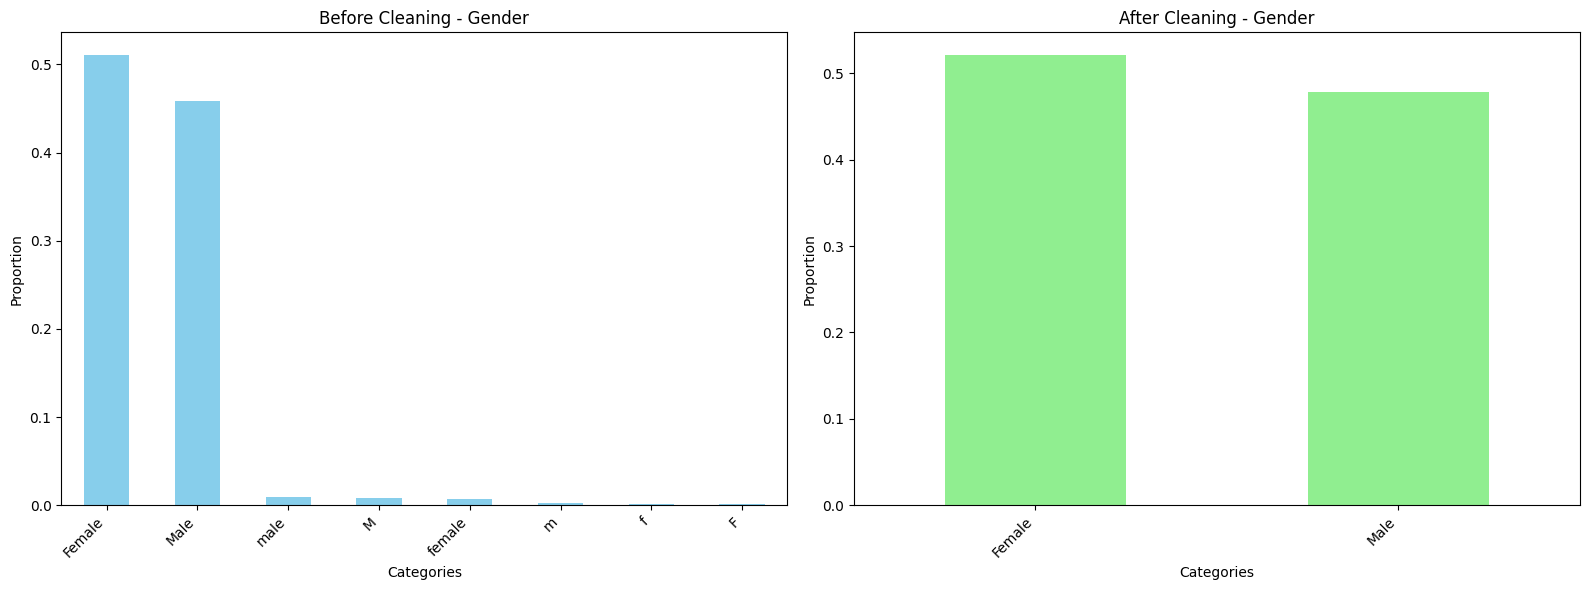

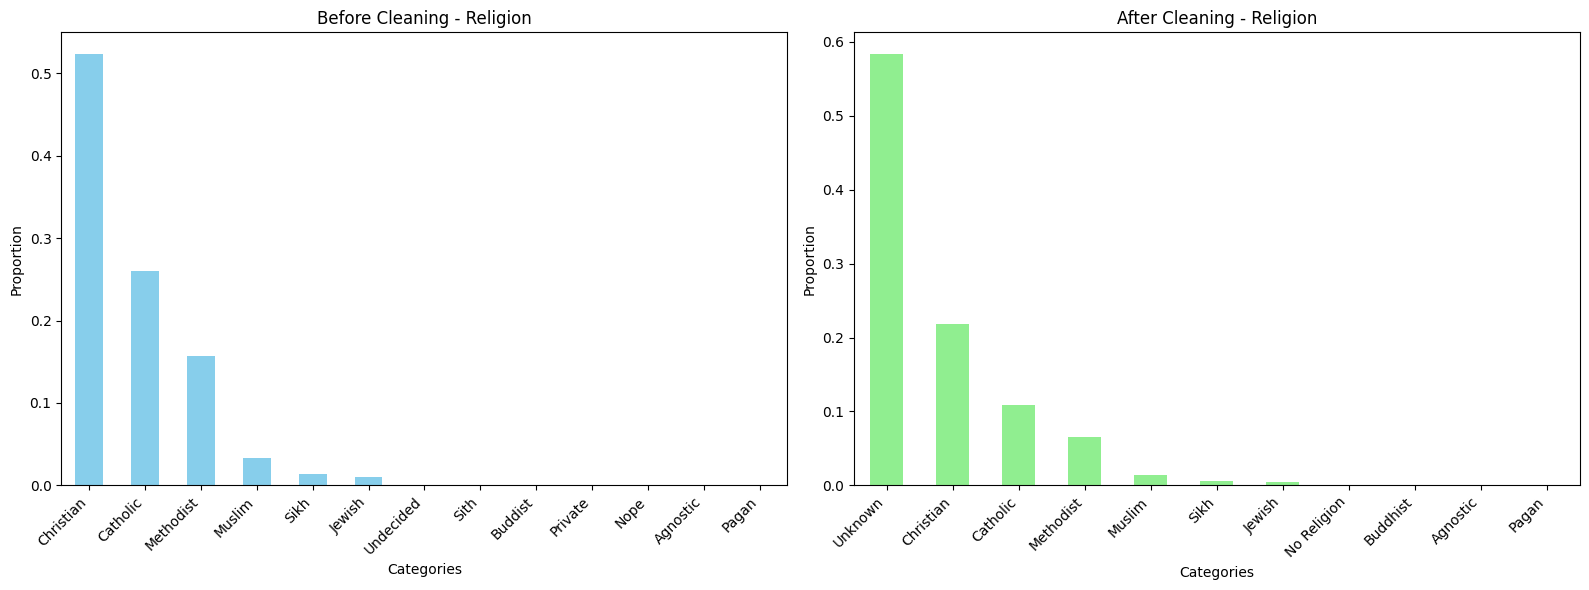

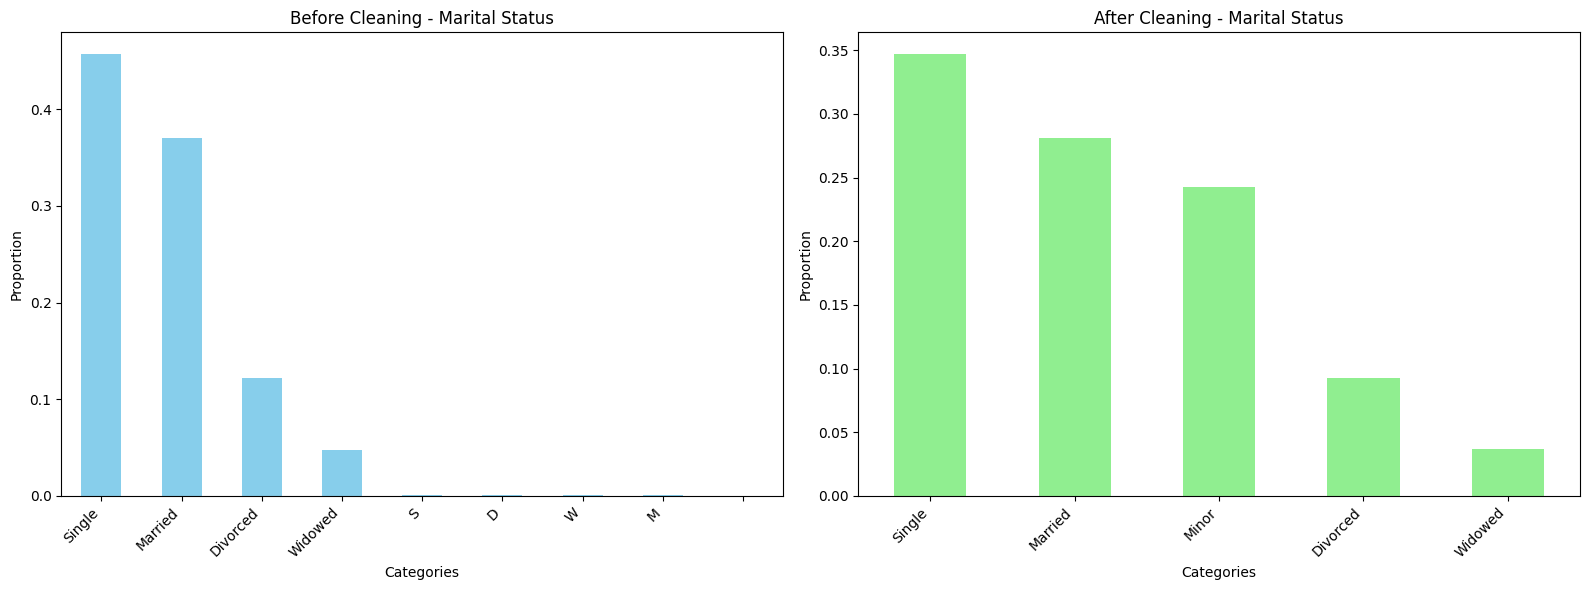

In [7]:
compare_old_and_cleaned_data(original_df, cleaned_df, columns_to_compare=['Gender', 'Religion', 'Marital Status'])


### Saving the cleaned dataset

In [8]:
# Save the final cleaned dataset
final_cleaned_df.to_csv("cleaned_dataset.csv", index=False)
print("\n Final cleaned data saved to 'cleaned_dataset.csv'")



 Final cleaned data saved to 'cleaned_dataset.csv'


### Exploratory Data Analysis
- Demographic distribution
- Religion insights
- Infirmity insights
- Household relationships
- Employment insights

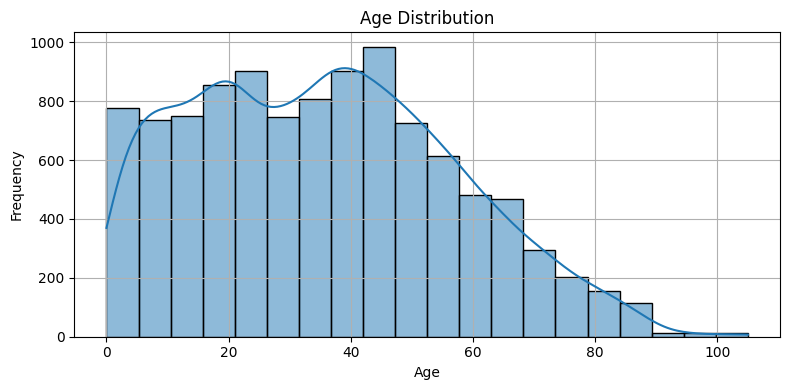


=== Gender Distribution Table ===
   Gender  Proportion (%)
0  Female       52.126954
1    Male       47.873046


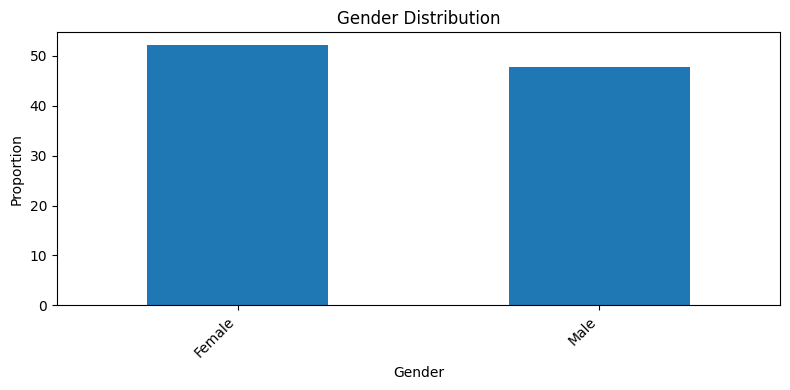


=== Marital Status Distribution Table ===
  Marital Status  Proportion (%)
0         Single       34.675509
1        Married       28.119375
2          Minor       24.272856
3       Divorced        9.275225
4        Widowed        3.657035


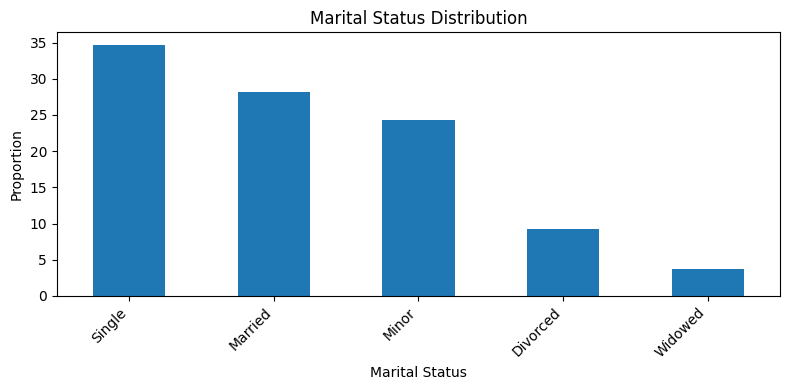


=== Religion by Age Group Table ===
Religion  Agnostic  Buddhist  Catholic  Christian  Jewish  Methodist  Muslim  \
Age                                                                            
0-18          0.00      0.00      0.57       1.07    0.08       0.38    0.19   
19-35         0.04      0.07     12.75      20.44    0.74       8.81    3.01   
36-55         0.00      0.00     18.89      25.36    0.51       8.56    1.27   
56+           0.00      0.00      9.60      46.21    0.35       8.54    1.01   

Religion  No Religion  Pagan  Sikh  Unknown  
Age                                          
0-18             0.00   0.00  0.00    97.71  
19-35            0.15   0.00  1.45    52.55  
36-55            0.06   0.03  0.48    44.85  
56+              0.00   0.00  0.30    33.99  


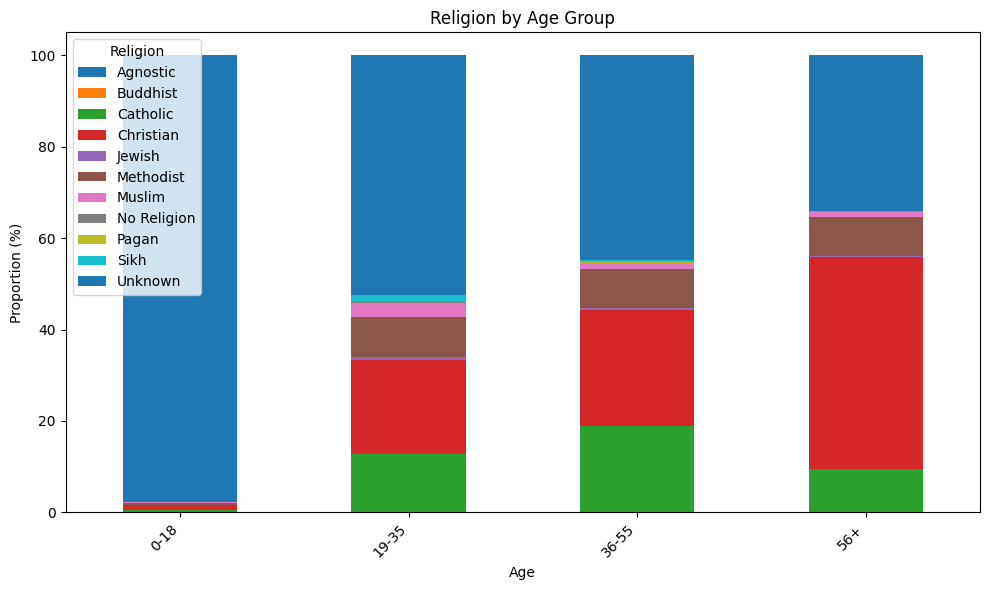


=== Religion by Marital Status Table ===
Marital Status  Divorced  Married  Minor  Single  Widowed
Religion                                                 
Agnostic            0.00     0.00   0.00  100.00     0.00
Buddhist            0.00   100.00   0.00    0.00     0.00
Catholic           11.45    38.90   0.00   45.80     3.85
Christian          13.39    33.87   0.00   45.17     7.57
Jewish              8.89    26.67   0.00   60.00     4.44
Methodist          11.92    36.05   0.00   46.51     5.52
Muslim             14.38    31.51   0.00   49.32     4.79
No Religion         0.00    33.33   0.00   66.67     0.00
Pagan             100.00     0.00   0.00    0.00     0.00
Sikh               13.33    26.67   0.00   58.33     1.67
Unknown             6.88    23.01  41.58   26.58     1.95


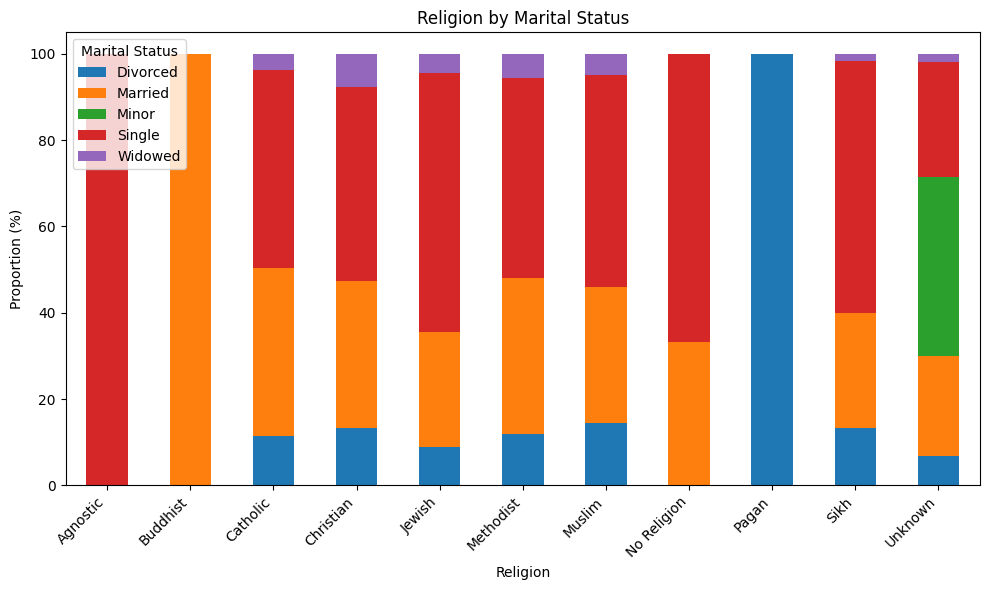


=== Infirmity by Age Group Table ===
Infirmity  Mental Disability  No infirmity  Physical Disability  Unknown
Age                                                                     
0-18                    0.08         99.39                 0.46     0.08
19-35                   0.11         99.18                 0.56     0.15
36-55                   0.03         99.14                 0.60     0.22
56+                     0.00         99.29                 0.71     0.00


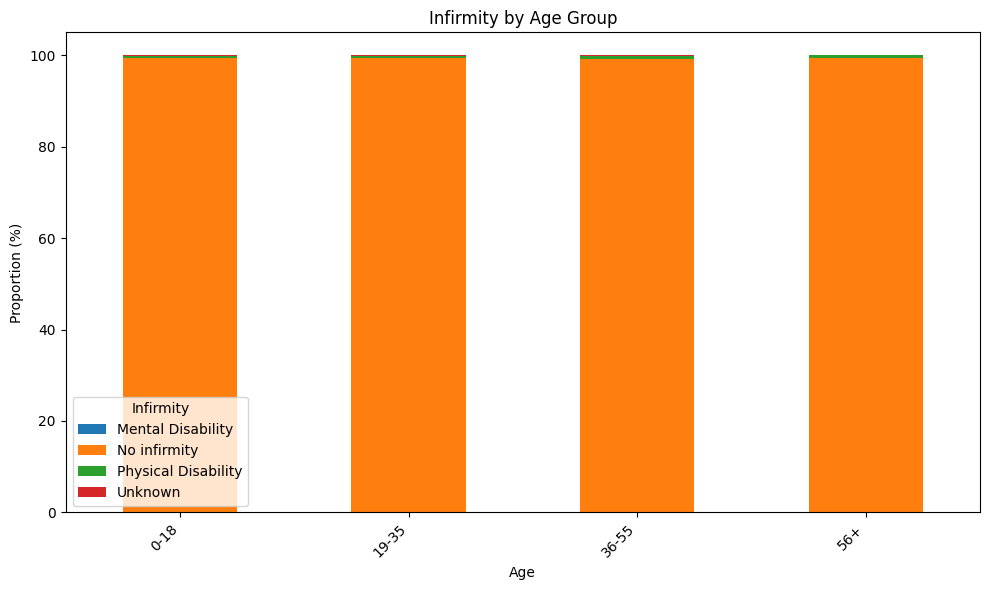


=== Types of Infirmities Table ===
Infirmity
No infirmity           10475
Physical Disability       61
Unknown                   13
Mental Disability          6
Name: count, dtype: int64


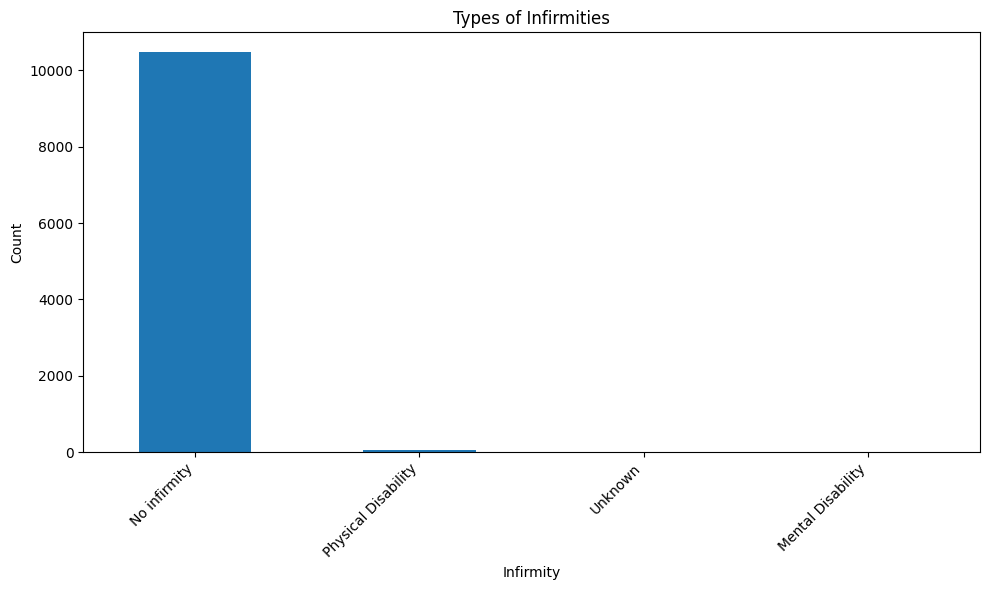


=== Household Composition Table ===
Relationship Group
Immediate Family    8953
Others              1229
Extended Family      335
In-Laws               38
Name: count, dtype: int64


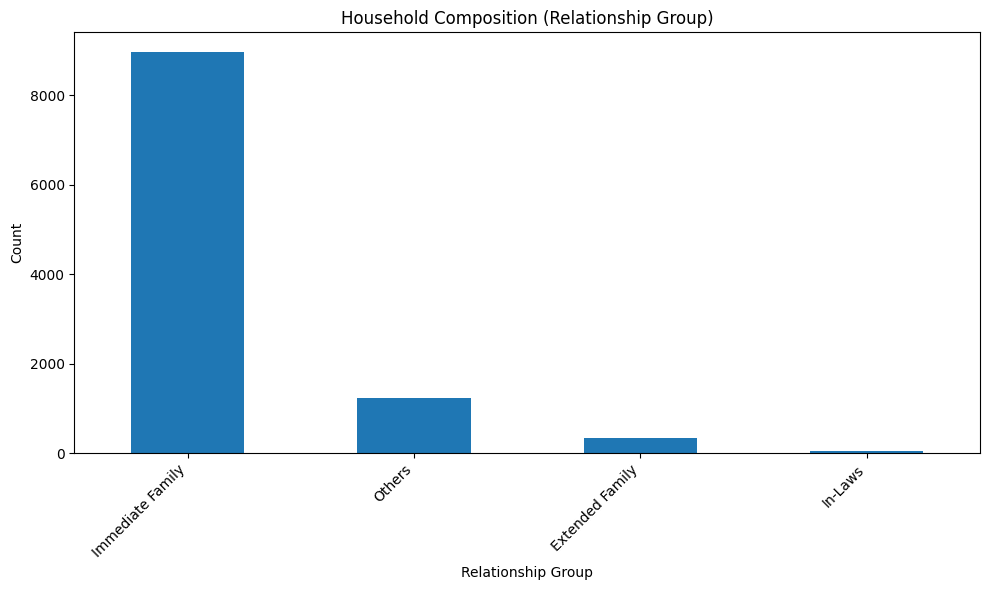


=== Relationship Group by Marital Status Table ===
Marital Status      Divorced  Married  Minor  Single  Widowed
Relationship Group                                           
Extended Family           35        0    205      89        6
Immediate Family         820     2947   2324    2505      357
In-Laws                    4        1     23      10        0
Others                   120       20     10    1056       23


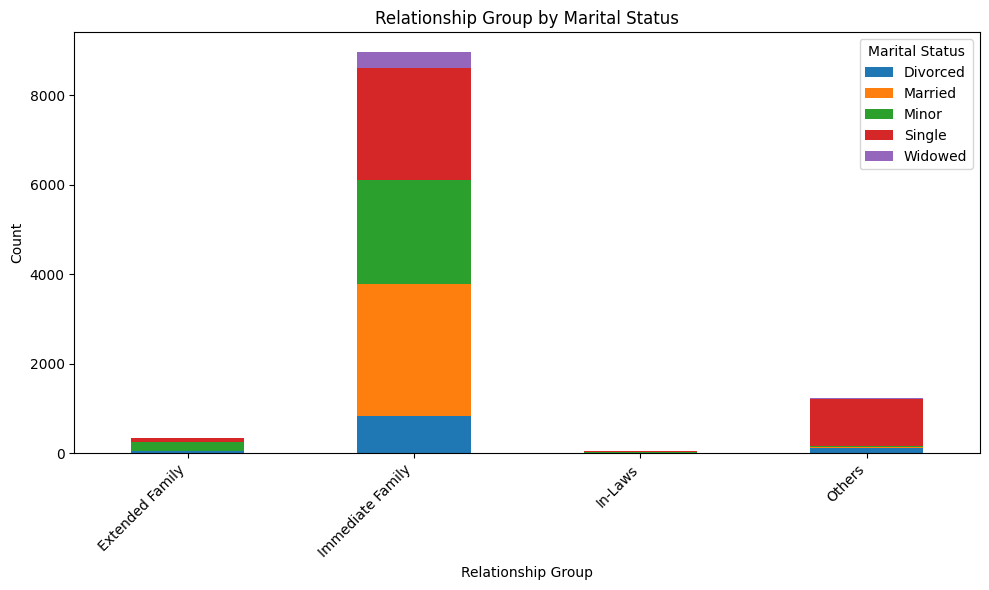


=== Employment Status Analysis ===

=== Employment Status Distribution Table ===
Employment Status
Child          5.89
Employed      61.49
Student       26.26
Unemployed     6.36
Name: proportion, dtype: float64


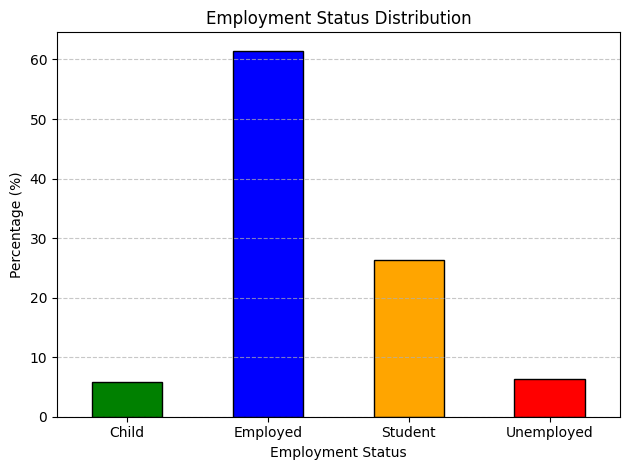

In [9]:
# Step 7: Explore the cleaned data
class DataExploration:
    def __init__(self, cleaned_df):
        self.df = cleaned_df

    def plot_distribution(self, column, title, xlabel):
        plt.figure(figsize=(8, 4))
        sns.histplot(self.df[column].dropna(), kde=True, bins=20)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_categorical_distribution(self, column):
        counts = self.df[column].value_counts(normalize=True) * 100
        df_table = counts.reset_index()
        df_table.columns = [column, 'Proportion (%)']

        print(f"\n=== {column} Distribution Table ===")
        print(df_table)

        plt.figure(figsize=(8, 4))
        counts.plot(kind='bar')
        plt.title(f'{column} Distribution')
        plt.ylabel("Proportion")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def demographic_distributions(self):
        self.plot_distribution('Age', 'Age Distribution', 'Age')
        self.plot_categorical_distribution('Gender')
        self.plot_categorical_distribution('Marital Status')

    def religion_insights(self):
        age_groups = pd.cut(self.df['Age'], bins=[0, 18, 35, 55, 100], labels=['0-18', '19-35', '36-55', '56+'])
        religion_by_age = pd.crosstab(age_groups, self.df['Religion'], normalize='index') * 100

        print("\n=== Religion by Age Group Table ===")
        print(religion_by_age.round(2))

        religion_by_age.plot(kind='bar', stacked=True, figsize=(10, 6))
        plt.title('Religion by Age Group')
        plt.ylabel("Proportion (%)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        religion_by_marital = pd.crosstab(self.df['Religion'], self.df['Marital Status'], normalize='index') * 100

        print("\n=== Religion by Marital Status Table ===")
        print(religion_by_marital.round(2))

        religion_by_marital.plot(kind='bar', stacked=True, figsize=(10, 6))
        plt.title('Religion by Marital Status')
        plt.ylabel("Proportion (%)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def occupation_insights(self):
        top_occupations = self.df['Occupation'].value_counts().head(10)

        print("\n=== Top Occupations Table ===")
        print(top_occupations)

        top_occupations.plot(kind='bar', figsize=(10, 6))
        plt.title('Top Occupations')
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        occupation_gender = pd.crosstab(self.df['Occupation'], self.df['Gender'])

        print("\n=== Occupation by Gender Table ===")
        print(occupation_gender)

        occupation_gender.plot(kind='bar', stacked=True, figsize=(10, 6))
        plt.title('Occupation by Gender')
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def infirmity_analysis(self):
        age_groups = pd.cut(self.df['Age'], bins=[0, 18, 35, 55, 100], labels=['0-18', '19-35', '36-55', '56+'])
        infirmity_by_age = pd.crosstab(age_groups, self.df['Infirmity'], normalize='index') * 100

        print("\n=== Infirmity by Age Group Table ===")
        print(infirmity_by_age.round(2))

        infirmity_by_age.plot(kind='bar', stacked=True, figsize=(10, 6))
        plt.title('Infirmity by Age Group')
        plt.ylabel("Proportion (%)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        infirmity_counts = self.df['Infirmity'].value_counts()

        print("\n=== Types of Infirmities Table ===")
        print(infirmity_counts)

        infirmity_counts.plot(kind='bar', figsize=(10, 6))
        plt.title('Types of Infirmities')
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def household_relationships(self):
        relationship_group_composition = self.df['Relationship Group'].value_counts()

        print("\n=== Household Composition Table ===")
        print(relationship_group_composition)

        relationship_group_composition.plot(kind='bar', figsize=(10, 6))
        plt.title('Household Composition (Relationship Group)')
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        relationship_group_marital_status = pd.crosstab(self.df['Relationship Group'], self.df['Marital Status'])

        print("\n=== Relationship Group by Marital Status Table ===")
        print(relationship_group_marital_status)

        relationship_group_marital_status.plot(kind='bar', stacked=True, figsize=(10, 6))
        plt.title('Relationship Group by Marital Status')
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def employment_analysis(self):
        print("\n=== Employment Status Analysis ===")

        df = self.df  # work with self.df

        # Step 1: Default everyone to 'Unemployed'
        df['Employment Status'] = 'Unemployed'

        # Step 2: Assign 'Student'
        df.loc[df['Occupation'].str.lower() == 'student', 'Employment Status'] = 'Student'

        # Step 3: Assign 'Child'
        df.loc[
            ((df['Occupation'].str.lower() == 'child') & (df['Age'] < 18)) |
            ((df['Age'] < 18) & (df['Occupation'].isna() | (df['Occupation'].str.strip() == ''))),
            'Employment Status'
        ] = 'Child'

        # Step 4: Assign 'Employed'
        df.loc[
            (df['Occupation'].notna()) & (~df['Occupation'].str.lower().isin(['student', 'child', 'unemployed'])),
            'Employment Status'
        ] = 'Employed'

        # Step 5: Summary
        employment_summary = df['Employment Status'].value_counts(normalize=True) * 100
        employment_summary = employment_summary.sort_index()

        print("\n=== Employment Status Distribution Table ===")
        print(employment_summary.round(2))

        # Step 6: Plot
        colors = ['green', 'blue', 'orange', 'red']
        employment_summary.plot(kind='bar', color=colors, edgecolor='black')
        plt.title('Employment Status Distribution')
        plt.ylabel('Percentage (%)')
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        self.df = df

    def advanced_analysis(self):
        raise NotImplementedError("Advanced analysis has not been implemented yet.")

    def run_all_analysis(self):
        print("Running Demographic Distributions...")
        self.demographic_distributions()

        print("Running Religion Insights...")
        self.religion_insights()

        print("Running Occupation Insights...")
        self.occupation_insights()

        print("Running Infirmity Analysis...")
        self.infirmity_analysis()

        print("Running Household Relationships...")
        self.household_relationships()

        print("Advanced analysis (optional) could go here.")


explorer = DataExploration(final_cleaned_df)
explorer.demographic_distributions()
explorer.religion_insights()
explorer.infirmity_analysis()
explorer.household_relationships()
analysis_df = explorer.employment_analysis()

### High-density vs Low-density housing recommendation

In [10]:
class HousingAnalysis:
    def __init__(self, cleaned_df):
        self.df = cleaned_df

    def run_analysis(self):
        # Analyze marital status and family size
        married_percentage = self.df[self.df['Marital Status'] == 'Married'].shape[0] / self.df.shape[0] * 100
        single_percentage = self.df[self.df['Marital Status'] == 'Single'].shape[0] / self.df.shape[0] * 100
        minor_percentage = self.df[self.df['Marital Status'] == 'Minor'].shape[0] / self.df.shape[0] * 100
        divorced_percentage = self.df[self.df['Marital Status'] == 'Divorced'].shape[0] / self.df.shape[0] * 100
        widowed_percentage = self.df[self.df['Marital Status'] == 'Widowed'].shape[0] / self.df.shape[0] * 100

        # Check for affluent occupations
        affluent_occupations = ['Manager', 'Executive', 'Lawyer', 'Doctor', 'Business Owner', 'CEO', 'Entrepreneur', 'Consultant']
        self.df['Affluent Occupation'] = self.df['Occupation'].apply(lambda x: any(occupation in x for occupation in affluent_occupations))

        affluent_population_percentage = self.df['Affluent Occupation'].mean() * 100

        # Analyze family group composition
        relationship_group_composition = self.df['Relationship Group'].value_counts(normalize=True) * 100
        immediate_family_percentage = relationship_group_composition.get('Immediate Family', 0)
        extended_family_percentage = relationship_group_composition.get('Extended Family', 0)
        others_percentage = relationship_group_composition.get('Others', 0)
        in_laws_percentage = relationship_group_composition.get('In-Laws', 0)

        # Housing Type Recommendation based on conditions
        if single_percentage > 30 and minor_percentage > 20:
            housing_type = 'High-Density Housing Needed (Growing Population)'
        elif immediate_family_percentage > 80 and extended_family_percentage < 5:
            housing_type = 'Low-Density Housing Needed (Affluent Families)'
        else:
            housing_type = 'Mixed Housing Needs (Both High and Low Density)'

        # Prepare the results table
        result_table = pd.DataFrame({
            'Category': ['Married', 'Single', 'Minor', 'Divorced', 'Widowed', 'Affluent Occupation', 'Immediate Family', 
                         'Extended Family', 'Others', 'In-Laws', 'Housing Type'],
            'Percentage': [
                married_percentage, single_percentage, minor_percentage, divorced_percentage, widowed_percentage,
                affluent_population_percentage, immediate_family_percentage, extended_family_percentage, 
                others_percentage, in_laws_percentage, housing_type
            ]
        })

        return result_table

    def visualize_data(self, marital_status_data, family_group_composition_data):
        # Visualizations for marital status and family group composition
        marital_status = ['Married', 'Single', 'Minor', 'Divorced', 'Widowed']
        marital_percentages = [marital_status_data['Married'], marital_status_data['Single'], marital_status_data['Minor'], 
                               marital_status_data['Divorced'], marital_status_data['Widowed']]

        plt.figure(figsize=(10, 6))
        sns.barplot(x=marital_status, y=marital_percentages, palette="Set2")
        plt.title('Marital Status Distribution')
        plt.ylabel('Percentage')
        plt.show()

        family_groups = ['Immediate Family', 'Extended Family', 'Others', 'In-Laws']
        family_percentages = [family_group_composition_data['Immediate Family'], family_group_composition_data['Extended Family'],
                              family_group_composition_data['Others'], family_group_composition_data['In-Laws']]

        plt.figure(figsize=(8, 8))
        plt.pie(family_percentages, labels=family_groups, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3", 4))
        plt.title('Family Group Composition')
        plt.axis('equal')
        plt.show()
        
housingAnalysis = HousingAnalysis(final_cleaned_df)
housingAnalysis.run_analysis()

,Category,Percentage
0,Married,28.119375
1,Single,34.675509
2,Minor,24.272856
3,Divorced,9.275225
4,Widowed,3.657035
5,Affluent Occupation,0.312648
6,Immediate Family,84.822359
7,Extended Family,3.173851
8,Others,11.643771
9,In-Laws,0.360019


### Commutter (Train station) recommendation

Total Population: 10555
Number of Likely Commuters: 9217
Percentage of Likely Commuters: 87.32%
Conclusion: HIGH number of commuters detected. Building a train station is a good idea.


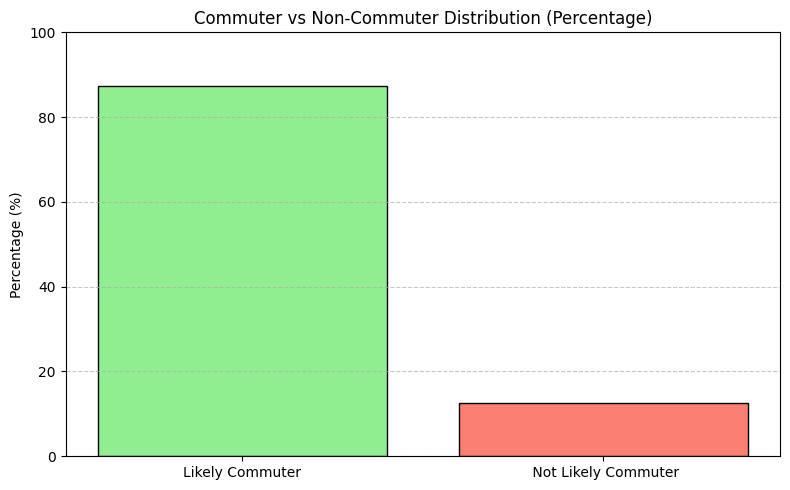

In [11]:
class CommuterAnalysis:
    def __init__(self, cleaned_df):
        self.df = cleaned_df

    def classify_professional_occupation(self, occupation):
        non_professional_keywords = ['student', 'child', 'unemployed']
        if any(keyword.lower() in str(occupation).lower() for keyword in non_professional_keywords):
            return False
        else:
            return True

    def employment_analysis(self):
        df = self.df
        df['Employment Status'] = 'Unemployed'

        df.loc[df['Occupation'].str.lower() == 'student', 'Employment Status'] = 'Student'

        df.loc[
            ((df['Occupation'].str.lower() == 'child') & (df['Age'] < 18)) |
            ((df['Age'] < 18) & (df['Occupation'].isna() | (df['Occupation'].str.strip() == ''))),
            'Employment Status'
        ] = 'Child'

        df.loc[
            (df['Occupation'].notna()) &
            (~df['Occupation'].str.lower().isin(['student', 'child', 'unemployed'])),
            'Employment Status'
        ] = 'Employed'

        self.df = df

    def run_analysis(self):
        self.employment_analysis()

        # Classify professional occupation
        self.df['Is Professional Occupation'] = self.df['Occupation'].apply(self.classify_professional_occupation)

        # Identify students based on Occupation
        self.df['Is Student'] = self.df['Occupation'].str.lower() == 'student'

        # Identify likely commuters
        self.df['Is Likely Commuter'] = self.df['Is Professional Occupation'] | self.df['Is Student']

        # Calculate numbers
        total_population = self.df.shape[0]
        num_commuters = self.df[self.df['Is Likely Commuter']].shape[0]
        commuter_percentage = (num_commuters / total_population) * 100

        print(f"Total Population: {total_population}")
        print(f"Number of Likely Commuters: {num_commuters}")
        print(f"Percentage of Likely Commuters: {commuter_percentage:.2f}%")

        if commuter_percentage >= 50:
            print("Conclusion: HIGH number of commuters detected. Building a train station is a good idea.")
        else:
            print("Conclusion: LOW number of commuters. A train station might not be urgently needed.")

       # NEW Bar Chart: Commuter vs Non-Commuter (PERCENTAGE)
        commuter_counts = self.df['Is Likely Commuter'].value_counts(normalize=True) * 100
        commuter_labels = ['Likely Commuter', ' Not Likely Commuter']

        plt.figure(figsize=(8, 5))
        plt.bar(commuter_labels, commuter_counts, color=['lightgreen', 'salmon'], edgecolor='black')
        plt.title('Commuter vs Non-Commuter Distribution (Percentage)')
        plt.ylabel('Percentage (%)')
        plt.ylim(0, 100)  # Force Y axis to go from 0 to 100%
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        
analysis = CommuterAnalysis(final_cleaned_df)
analysis.run_analysis()

###  Religious building recommendation

In [12]:
class ReligionAnalysis:
    def __init__(self, df):
        self.df = df

    def religion_insights(self):
        # Religion Distribution
        religion_distribution = self.df['Religion'].value_counts(normalize=True) * 100
        
        # Consolidate Christian Group for Demand Analysis
        christian_denominations = ['Catholic', 'Methodist', 'Christian']  # Adjust based on actual column names
        christian_group_percentage = religion_distribution.get('Christian', 0) + sum(religion_distribution.get(denomination, 0) for denomination in christian_denominations)
        
        # Determine recommended action based on religion distribution
        if christian_group_percentage > 5:
            return "Recommendation: Consider establishing a second Christian church to accommodate the significant Christian population."
        
        if religion_distribution.get('Muslim', 0) > 0.5:
            return "Recommendation: Consider establishing a mosque due to the significant Muslim population."
        
        if religion_distribution.get('Sikh', 0) > 0.5:
            return "Recommendation: Consider establishing a Sikh temple to accommodate the Sikh population."
        
        return "No significant demand identified for additional religious buildings."

religion_analysis = ReligionAnalysis(final_cleaned_df)
religion_analysis.religion_insights()

'Recommendation: Consider establishing a second Christian church to accommodate the significant Christian population.'

### Emergency medical building recommendations

Based on the data, it is recommended to build a minor injuries centre. The high proportion of working individuals and students suggests frequent activity-related injuries that would benefit from accessible, localized medical care.


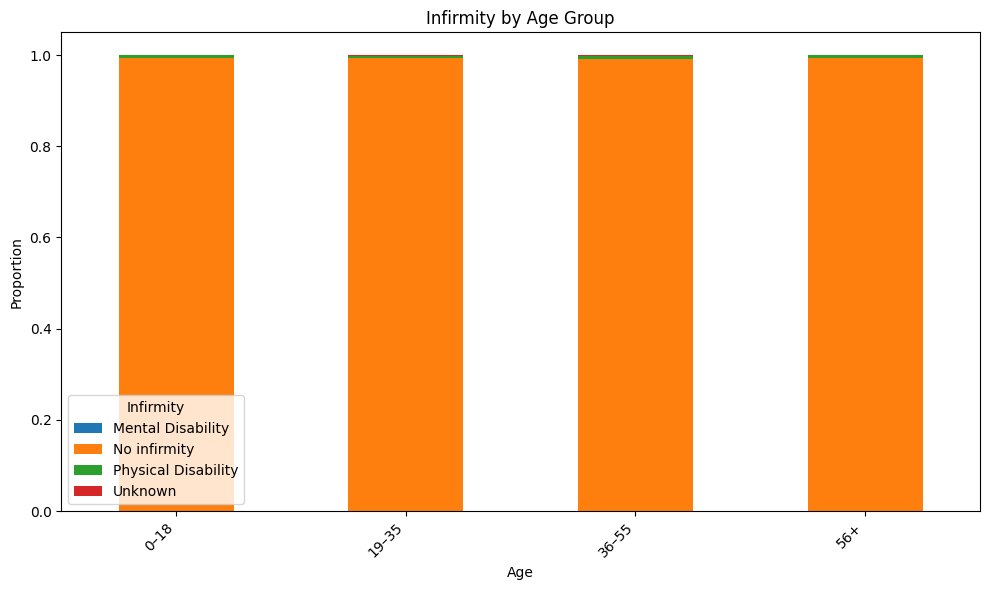

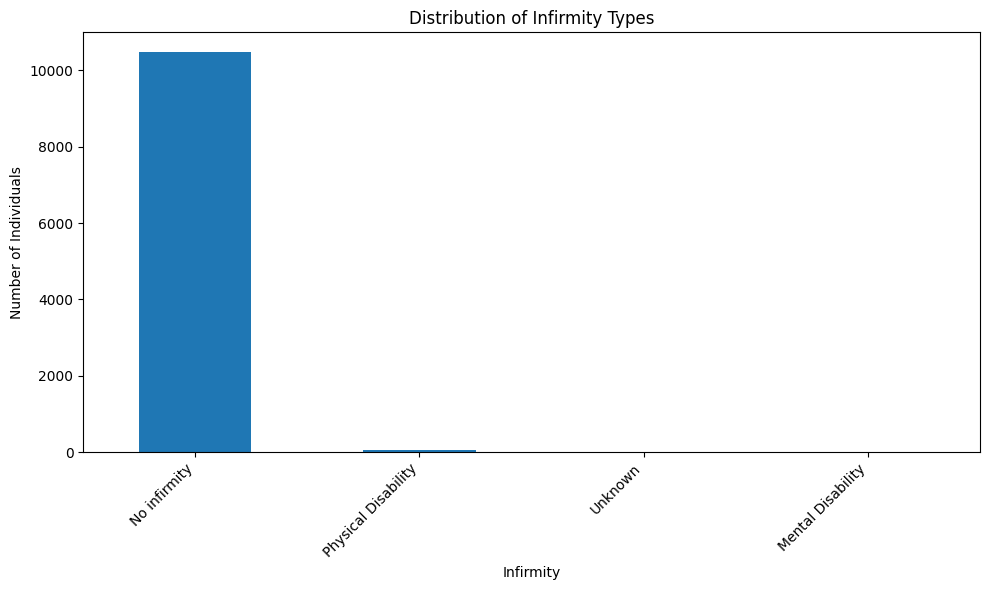

In [13]:
class MedicalBuildingAnalysis:
    def __init__(self, df):
        self.df = df.copy()

    def calculate_dynamic_threshold(self, column, lower_percentile=10, upper_percentile=90):
        """Calculate thresholds using percentiles to identify typical ranges in numeric data."""
        if not np.issubdtype(self.df[column].dtype, np.number):
            print(f"Warning: Column '{column}' is not numeric. Attempting to convert.")
            self.df[column] = pd.to_numeric(self.df[column], errors='coerce')

        valid_data = self.df[column].dropna()
        if not valid_data.empty:
            lower_threshold = np.percentile(valid_data, lower_percentile)
            upper_threshold = np.percentile(valid_data, upper_percentile)
            return lower_threshold, upper_threshold
        else:
            print(f"No valid data found for column '{column}'.")
            return None, None

    def infirmity_analysis(self):
        """Visualize the distribution of infirmities by age group and category."""
        age_groups = pd.cut(self.df['Age'], bins=[0, 18, 35, 55, 100], labels=['0–18', '19–35', '36–55', '56+'])
        infirmity_by_age = pd.crosstab(age_groups, self.df['Infirmity'], normalize='index')
        infirmity_by_age.plot(kind='bar', stacked=True, figsize=(10, 6))
        plt.title('Infirmity by Age Group')
        plt.ylabel("Proportion")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        infirmity_counts = self.df['Infirmity'].value_counts()
        infirmity_counts.plot(kind='bar', figsize=(10, 6))
        plt.title('Distribution of Infirmity Types')
        plt.ylabel("Number of Individuals")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def medical_insights(self):
        """Generate a recommendation on whether a medical building is needed, based on key population indicators."""
        required_columns = ['Age', 'Gender', 'Infirmity', 'Employment Status', 'Occupation']
        for col in required_columns:
            if col not in self.df.columns:
                return f"Error: The dataset is missing a required column: '{col}'."

        age_lower, age_upper = self.calculate_dynamic_threshold('Age')
        if age_lower is None or age_upper is None:
            return "Error: Unable to compute age thresholds due to invalid or missing data."

        # Indicator 1: Likelihood of injuries among typical working-age population
        injury_group = self.df[(self.df['Age'] >= age_lower) & (self.df['Age'] <= age_upper)]
        injury_likelihood_pct = len(injury_group) / len(self.df) * 100
        injury_risk = injury_likelihood_pct > 20

        # Indicator 2: Active population – employed or students
        is_employed = self.df['Employment Status'].str.lower().eq('employed')
        is_student = self.df['Occupation'].str.lower().str.contains('student', na=False)
        employed_or_students = self.df[is_employed | is_student]
        employed_student_pct = len(employed_or_students) / len(self.df) * 100
        employed_student_risk = employed_student_pct > 50

        # Indicator 3: Women of childbearing age (18–35)
        women_18_35 = self.df[
            (self.df['Gender'].str.lower() == 'female') &
            (self.df['Age'].between(18, 35))
        ]
        women_18_35_pct = len(women_18_35) / len(self.df) * 100
        women_childbearing_risk = women_18_35_pct > 10

        # Indicator 4: Physical disability prevalence
        physical_disability_pct = (self.df['Infirmity'] == 'Physical Disability').mean() * 100
        disability_risk = physical_disability_pct > 0.5

        # Generate recommendation
        if injury_risk and employed_student_risk:
            return ("Based on the data, it is recommended to build a minor injuries centre. "
                    "The high proportion of working individuals and students suggests frequent activity-related injuries "
                    "that would benefit from accessible, localized medical care.")

        if women_childbearing_risk:
            return ("A minor injuries centre with maternity and child health support is advisable. "
                    "The town has a significant population of women aged 18–35, who may benefit from reproductive and paediatric services.")

        if disability_risk:
            return ("A medical facility offering basic support for individuals with physical disabilities could be valuable. "
                    "Although the percentage is low, it exceeds the typical planning threshold.")

        if injury_likelihood_pct > 15 and (disability_risk or women_childbearing_risk):
            return ("Consider developing a flexible care facility that provides general injury treatment along with maternal or disability services. "
                    "This would address a broader set of needs based on population demographics.")

        return ("There is currently no strong demographic demand for building a new minor injuries centre. "
                "Existing medical infrastructure appears sufficient for the town’s present needs.")


#usage
medical_analysis = MedicalBuildingAnalysis(final_cleaned_df)
print(medical_analysis.medical_insights())
medical_analysis.infirmity_analysis()

### Employment and training investment recommendations


=== Employment Status Analysis ===

Employment Status Distribution:
Employment Status
Child          5.892942
Employed      61.487447
Student       26.262435
Unemployed     6.357177
Name: proportion, dtype: float64


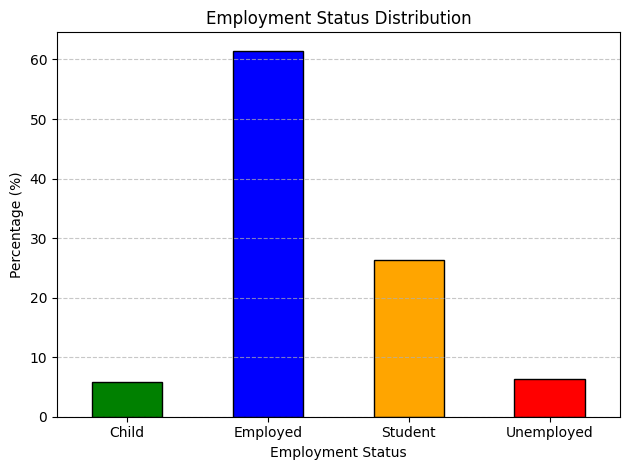


Unemployment Rate: 6.36%

Unemployment rate is below the threshold. Employment and training investment is not urgently needed.


None

In [14]:
class EmploymentAnalysis:
    def __init__(self, df):
        self.df = df

    def employment_analysis(self):
        print("\n=== Employment Status Analysis ===")

        df = self.df  # work with self.df

        # Step 1: Default everyone to 'Unemployed'
        df['Employment Status'] = 'Unemployed'

        # Step 2: Assign 'Student'
        df.loc[df['Occupation'].str.lower() == 'student', 'Employment Status'] = 'Student'

        # Step 3: Assign 'Child'
        df.loc[
            ((df['Occupation'].str.lower() == 'child') & (df['Age'] < 18)) |
            ((df['Age'] < 18) & (df['Occupation'].isna() | (df['Occupation'].str.strip() == ''))),
            'Employment Status'
        ] = 'Child'

        # Step 4: Assign 'Employed'
        df.loc[
            (df['Occupation'].notna()) & 
            (~df['Occupation'].str.lower().isin(['student', 'child', 'unemployed'])),
            'Employment Status'
        ] = 'Employed'

        # Step 5: Summary
        employment_summary = df['Employment Status'].value_counts(normalize=True) * 100
        employment_summary = employment_summary.sort_index()

        print("\nEmployment Status Distribution:")
        print(employment_summary)

        # Step 6: Plot
        colors = ['green', 'blue', 'orange', 'red']
        employment_summary.plot(kind='bar', color=colors, edgecolor='black')
        plt.title('Employment Status Distribution')
        plt.ylabel('Percentage (%)')
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Step 7: Calculate unemployment rate
        unemployment_rate = employment_summary.get('Unemployed', 0)
        print(f"\nUnemployment Rate: {unemployment_rate:.2f}%")

        # Step 8: Analyze if investment in employment and training is needed
        self.evaluate_training_investment(unemployment_rate)

        self.df = df  # save the updated dataframe

    def evaluate_training_investment(self, unemployment_rate):
        """
        Evaluate whether to invest in employment and training based on the unemployment rate.
        """
        # Define threshold for significant unemployment (e.g., 10%)
        unemployment_threshold = 10  # You can adjust this threshold as needed
        
        if unemployment_rate > unemployment_threshold:
            print("\nInvestment in employment and training is recommended!")
            print("The unemployment rate is significant, indicating a need for retraining individuals for new skills.")
            
            # Further analysis of potential causes (optional)
            self.analyze_skill_gaps()
        else:
            print("\nUnemployment rate is below the threshold. Employment and training investment is not urgently needed.")

    def analyze_skill_gaps(self):
        """
        Analyze skill gaps or other reasons for unemployment. This function can be expanded.
        """
        print("\nAnalyzing skill gaps or reasons for unemployment...")
        # For now, just a placeholder for further analysis, which could be based on occupation, age, etc.
        
        # Example: Count unemployed people by age to see if there's a pattern.
        unemployed_by_age = self.df[self.df['Employment Status'] == 'Unemployed'].groupby('Age').size()
        print("\nUnemployed count by Age:")
        print(unemployed_by_age)

        # Example: Count unemployed people by occupation to check for skill mismatch.
        unemployed_by_occupation = self.df[self.df['Employment Status'] == 'Unemployed'].groupby('Occupation').size()
        print("\nUnemployed count by Occupation:")
        print(unemployed_by_occupation)

employment_analysis = EmploymentAnalysis(final_cleaned_df)
summary = employment_analysis.employment_analysis()
display(summary)

def infirmity_analysis_combined(self):
    """
    Combined visualization of:
    - Infirmity proportions by age group (stacked bar)
    - Total counts of infirmity types (bar)
    """

    # Define age groups
    age_groups = pd.cut(self.df['Age'], bins=[0, 18, 35, 55, 100], labels=['0–18', '19–35', '36–55', '56+'])
    self.df['Age Group'] = age_groups

    # Prepare data
    infirmity_by_age = pd.crosstab(self.df['Age Group'], self.df['Infirmity'], normalize='index')
    infirmity_counts = self.df['Infirmity'].value_counts()

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Proportion by age group
    infirmity_by_age.plot(kind='bar', stacked=True, ax=axes[0], colormap='Set2')
    axes[0].set_title('Proportion of Infirmity Types by Age Group')
    axes[0].set_xlabel('Age Group')
    axes[0].set_ylabel('Proportion')
    axes[0].legend(title='Infirmity', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].tick_params(axis='x', rotation=0)

    # Plot 2: Total counts of infirmities
    sns.barplot(x=infirmity_counts.index, y=infirmity_counts.values, ax=axes[1], palette='Blues_d')
    axes[1].set_title('Total Count of Infirmity Types')
    axes[1].set_xlabel('Infirmity Type')
    axes[1].set_ylabel('Count')
    axes[1].tick_params(axis='x', rotation=45)

    # Layout adjustment
    plt.tight_layout()
    plt.show()

### Old age care investment recommendations


Key Assumptions:
Elderly Threshold: People aged 65 and above are considered elderly.

Retirement Assumption: People aged 65 and above are likely retired or will soon retire.



=== Old Age Care Analysis ===

Percentage of Elderly Population (65+): 10.16%
Percentage of Retired Population: 10.16%

=== Allocation Decision for Old Age Care ===
Significant elderly population detected. Allocate more resources for old age care (Elderly: 10.16%).


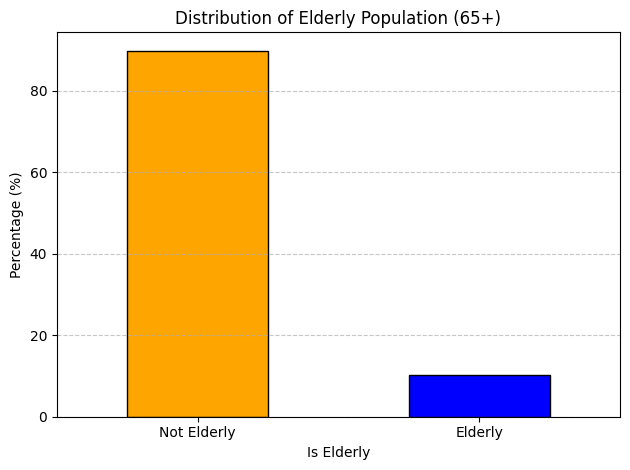

In [15]:
class OldAgeCareAnalysis:
    def __init__(self, df):
        self.df = df

    def analyze_old_age_care(self):
        print("\n=== Old Age Care Analysis ===")

        df = self.df  # work with self.df

        # Step 1: Define age threshold for elderly (65 and above)
        elderly_threshold = 65  # 65 and above is generally considered elderly for care purposes

        # Step 2: Identify elderly individuals (65 years and above)
        df['Is Elderly'] = df['Age'] >= elderly_threshold

        # Step 3: Calculate the percentage of elderly people
        elderly_percentage = df['Is Elderly'].mean() * 100
        print(f"\nPercentage of Elderly Population (65+): {elderly_percentage:.2f}%")

        # Step 4: Identify retirement status (Retired people are typically 65 and above)
        df['Is Retired'] = df['Age'] >= elderly_threshold

        # Step 5: Calculate the percentage of retired people
        retired_percentage = df['Is Retired'].mean() * 100
        print(f"Percentage of Retired Population: {retired_percentage:.2f}%")

        # Step 6: Analyze the need for old age care based on the percentage of elderly
        self.allocate_resources_for_care(elderly_percentage)

        # Optional: Plot the distribution of elderly individuals
        self.plot_elderly_distribution(df)

    def allocate_resources_for_care(self, elderly_percentage):
        """
        This method will recommend whether to allocate more funding for old age care.
        """
        print("\n=== Allocation Decision for Old Age Care ===")

        # If the elderly percentage is above a threshold, we recommend allocating resources.
        elderly_threshold_percentage = 10  # 10% threshold for significant elderly population

        if elderly_percentage > elderly_threshold_percentage:
            print(f"Significant elderly population detected. Allocate more resources for old age care (Elderly: {elderly_percentage:.2f}%).")
        else:
            print(f"Elderly population is not significant enough to warrant immediate action (Elderly: {elderly_percentage:.2f}%).")

    def plot_elderly_distribution(self, df):
        """Optional method to plot the distribution of elderly individuals."""
        elderly_count = df['Is Elderly'].value_counts(normalize=True) * 100
        elderly_count = elderly_count.sort_index()

        # Plot distribution of elderly population
        colors = ['orange', 'blue']
        elderly_count.plot(kind='bar', color=colors, edgecolor='black')
        plt.title('Distribution of Elderly Population (65+)')
        plt.ylabel('Percentage (%)')
        plt.xticks([0, 1], ['Not Elderly', 'Elderly'], rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

old_age_care_analysis = OldAgeCareAnalysis(final_cleaned_df)
old_age_care_analysis.analyze_old_age_care()

### Increase spending for schooling recommendations


School-Aged Threshold: Children aged 5 to 18 are considered school-aged.



=== Schooling Investment Analysis ===

Percentage of School-Aged Children (5-18 years): 19.85%

=== Allocation Decision for Schooling Investment ===
Significant school-aged population detected. Increase spending for schooling (School-Aged: 19.85%).


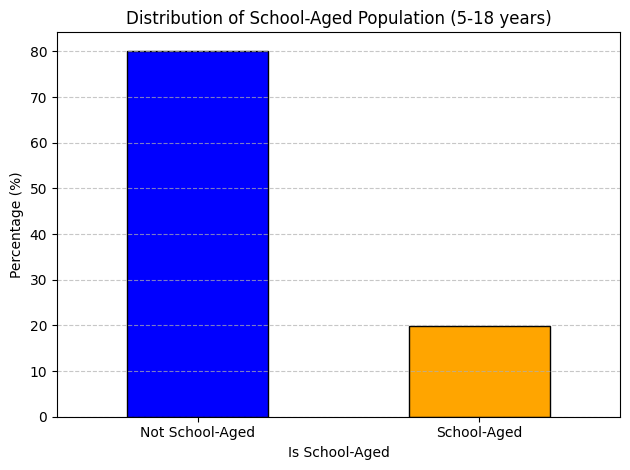

In [16]:
class SchoolingInvestmentAnalysis:
    def __init__(self, df):
        self.df = df

    def analyze_schooling_investment(self):
        print("\n=== Schooling Investment Analysis ===")

        df = self.df  # work with self.df

        # Step 1: Define age range for school-aged children (5 to 18)
        school_age_min = 5
        school_age_max = 18

        # Step 2: Identify school-aged children (ages between 5 and 18)
        df['Is School-Aged'] = (df['Age'] >= school_age_min) & (df['Age'] <= school_age_max)

        # Step 3: Calculate the percentage of school-aged children
        school_age_percentage = df['Is School-Aged'].mean() * 100
        print(f"\nPercentage of School-Aged Children (5-18 years): {school_age_percentage:.2f}%")

        # Step 4: Analyze the need for increased schooling investment based on the percentage of school-aged children
        self.allocate_resources_for_schooling(school_age_percentage)

        # Optional: Plot the distribution of school-aged children
        self.plot_school_age_distribution(df)

    def allocate_resources_for_schooling(self, school_age_percentage):
        """
        This method will recommend whether to increase investment in schooling.
        """
        print("\n=== Allocation Decision for Schooling Investment ===")

        # If the school-aged percentage is above a threshold, we recommend increasing resources.
        school_age_threshold_percentage = 15  # 15% threshold for significant school-aged population

        if school_age_percentage > school_age_threshold_percentage:
            print(f"Significant school-aged population detected. Increase spending for schooling (School-Aged: {school_age_percentage:.2f}%).")
        else:
            print(f"School-aged population is not significant enough to warrant immediate action (School-Aged: {school_age_percentage:.2f}%).")

    def plot_school_age_distribution(self, df):
        """Optional method to plot the distribution of school-aged children."""
        school_age_count = df['Is School-Aged'].value_counts(normalize=True) * 100
        school_age_count = school_age_count.sort_index()

        # Plot distribution of school-aged population
        colors = ['blue', 'orange']
        school_age_count.plot(kind='bar', color=colors, edgecolor='black')
        plt.title('Distribution of School-Aged Population (5-18 years)')
        plt.ylabel('Percentage (%)')
        plt.xticks([0, 1], ['Not School-Aged', 'School-Aged'], rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

schooling_investment_analysis = SchoolingInvestmentAnalysis(final_cleaned_df)

# Run the analysis
schooling_investment_analysis.analyze_schooling_investment()

### General infrastructure recommendations


=== General Infrastructure Investment Analysis ===
Percentage of Children (5-18): 19.85%
Percentage of Working-Age Adults (18-65): 66.34%
Percentage of Elderly (65+): 10.16%

=== Allocation Decision for General Infrastructure Investment ===
Significant population growth detected (Children: 19.85%, Working-Age: 66.34%). Increase investment in general infrastructure.


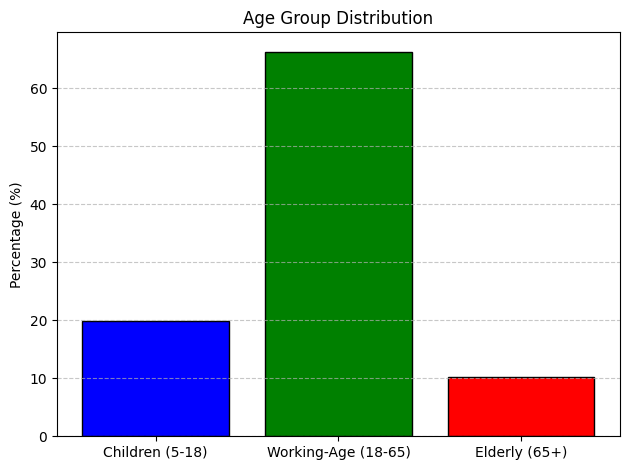

In [17]:
class InfrastructureInvestmentAnalysis:
    def __init__(self, df):
        self.df = df

    def analyze_infrastructure_investment(self):
        print("\n=== General Infrastructure Investment Analysis ===")

        df = self.df  # work with self.df

        # Define age groups for analysis
        children_age_range = (5, 18)  # 5-18 years old
        working_age_range = (18, 65)  # 18-65 years old
        elderly_age_range = (65, 100) # 65+ years old

        # Step 1: Calculate the proportion of children (5-18), working-age adults (18-65), and elderly (65+)
        children_count = df[(df['Age'] >= children_age_range[0]) & (df['Age'] <= children_age_range[1])].shape[0]
        working_age_count = df[(df['Age'] >= working_age_range[0]) & (df['Age'] <= working_age_range[1])].shape[0]
        elderly_count = df[(df['Age'] >= elderly_age_range[0])].shape[0]

        total_population = df.shape[0]

        # Calculate the percentage for each group
        children_percentage = (children_count / total_population) * 100
        working_age_percentage = (working_age_count / total_population) * 100
        elderly_percentage = (elderly_count / total_population) * 100

        # Output the results
        print(f"Percentage of Children (5-18): {children_percentage:.2f}%")
        print(f"Percentage of Working-Age Adults (18-65): {working_age_percentage:.2f}%")
        print(f"Percentage of Elderly (65+): {elderly_percentage:.2f}%")

        # Step 2: Decision logic for infrastructure investment
        self.allocate_resources_for_infrastructure(children_percentage, working_age_percentage)

        # Optional: Plot the age group distribution
        self.plot_age_group_distribution(children_percentage, working_age_percentage, elderly_percentage)

    def allocate_resources_for_infrastructure(self, children_percentage, working_age_percentage):
        """
        This method will recommend whether to increase investment in infrastructure based on population indicators.
        """
        print("\n=== Allocation Decision for General Infrastructure Investment ===")

        # Infrastructure should be increased if there is significant growth in children and working-age adults
        growth_threshold_percentage = 15  # Minimum percentage of children and working-age adults to recommend investment

        if children_percentage > growth_threshold_percentage or working_age_percentage > growth_threshold_percentage:
            print(f"Significant population growth detected (Children: {children_percentage:.2f}%, Working-Age: {working_age_percentage:.2f}%). Increase investment in general infrastructure.")
        else:
            print(f"Population growth not significant enough to warrant increased infrastructure spending (Children: {children_percentage:.2f}%, Working-Age: {working_age_percentage:.2f}%).")

    def plot_age_group_distribution(self, children_percentage, working_age_percentage, elderly_percentage):
        """Optional method to plot the age group distribution."""
        age_groups = ['Children (5-18)', 'Working-Age (18-65)', 'Elderly (65+)']
        percentages = [children_percentage, working_age_percentage, elderly_percentage]

        # Plot distribution of age groups
        colors = ['blue', 'green', 'red']
        plt.bar(age_groups, percentages, color=colors, edgecolor='black')
        plt.title('Age Group Distribution')
        plt.ylabel('Percentage (%)')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

infrastructure_investment_analysis = InfrastructureInvestmentAnalysis(final_cleaned_df)
infrastructure_investment_analysis.analyze_infrastructure_investment()